In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import rl_utils
from tqdm import tqdm
import matplotlib.pyplot as plt

! git clone https://gh-proxy.com/https://github.com/boyu-ai/ma-gym.git
import sys
sys.path.append("./ma-gym")
from ma_gym.envs.combat.combat import Combat

fatal: destination path 'ma-gym' already exists and is not an empty directory.


In [6]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return F.softmax(self.fc3(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return self.fc3(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        log_probs = torch.log(self.actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1 - self.eps,
                            1 + self.eps) * advantage  # 截断
        actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

In [7]:
actor_lr = 3e-4
critic_lr = 1e-3
num_episodes = 100000
hidden_dim = 64
gamma = 0.99
lmbda = 0.97
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

team_size = 2
grid_size = (15, 15)
#创建Combat环境，格子世界的大小为15x15，己方智能体和敌方智能体数量都为2
env = Combat(grid_shape=grid_size, n_agents=team_size, n_opponents=team_size)

state_dim = env.observation_space[0].shape[0]
action_dim = env.action_space[0].n
#两个智能体共享同一个策略
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, eps,
            gamma, device)

win_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            transition_dict_1 = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            transition_dict_2 = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            s = env.reset()
            terminal = False
            while not terminal:
                a_1 = agent.take_action(s[0])
                a_2 = agent.take_action(s[1])
                next_s, r, done, info = env.step([a_1, a_2])
                transition_dict_1['states'].append(s[0])
                transition_dict_1['actions'].append(a_1)
                transition_dict_1['next_states'].append(next_s[0])
                transition_dict_1['rewards'].append(
                    r[0] + 100 if info['win'] else r[0] - 0.1)
                transition_dict_1['dones'].append(False)
                transition_dict_2['states'].append(s[1])
                transition_dict_2['actions'].append(a_2)
                transition_dict_2['next_states'].append(next_s[1])
                transition_dict_2['rewards'].append(
                    r[1] + 100 if info['win'] else r[1] - 0.1)
                transition_dict_2['dones'].append(False)
                s = next_s
                terminal = all(done)
            win_list.append(1 if info["win"] else 0)
            agent.update(transition_dict_1)
            agent.update(transition_dict_2)
            if (i_episode + 1) % 100 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(win_list[-100:])
                })
            pbar.update(1)

# /usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning:[33mWARN:
# Box bound precision lowered by casting to float32[0m
#   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))

# Iteration 0: 100%|██████████| 10000/10000 [05:22<00:00, 31.02it/s, episode=10000,
# return=0.220]
# Iteration 1: 100%|██████████| 10000/10000 [04:03<00:00, 41.07it/s, episode=20000,
# return=0.400]
# Iteration 2: 100%|██████████| 10000/10000 [03:37<00:00, 45.96it/s, episode=30000,
# return=0.670]
# Iteration 3: 100%|██████████| 10000/10000 [03:13<00:00, 51.55it/s, episode=40000,
# return=0.590]
# Iteration 4: 100%|██████████| 10000/10000 [02:58<00:00, 56.07it/s, episode=50000,
# return=0.750]
# Iteration 5: 100%|██████████| 10000/10000 [02:58<00:00, 56.09it/s, episode=60000,
# return=0.660]
# Iteration 6: 100%|██████████| 10000/10000 [02:57<00:00, 56.42it/s, episode=70000,
# return=0.660]
# Iteration 7: 100%|██████████| 10000/10000 [03:04<00:00, 54.20it/s, episode=80000,
# return=0.720]
# Iteration 8: 100%|██████████| 10000/10000 [02:59<00:00, 55.84it/s, episode=90000,
# return=0.530]
# Iteration 9: 100%|██████████| 10000/10000 [03:03<00:00, 54.55it/s, episode=100000,
# return=0.710]

/home/z/miniconda3/envs/rl/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
Iteration 0:   0%|          | 0/10000 [00:00<?, ?it/s]/mnt/0dbb253c-43fe-4ab1-99c3-d9faf5863008/Hands-on-RL/rl_utils.py:89: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(advantage_list, dtype=torch.float)
Iteration 9: 100%|██████████| 10000/10000 [08:52<00:00, 18.78it/s, episode=100000, return=0.610]


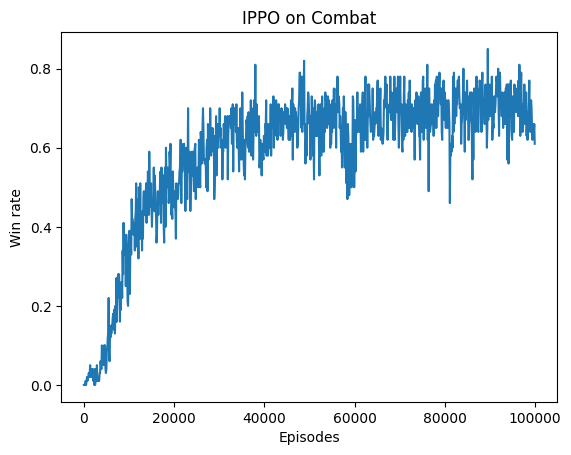

In [8]:
win_array = np.array(win_list)
#每100条轨迹取一次平均
win_array = np.mean(win_array.reshape(-1, 100), axis=1)

episodes_list = np.arange(win_array.shape[0]) * 100
plt.plot(episodes_list, win_array)
plt.xlabel('Episodes')
plt.ylabel('Win rate')
plt.title('IPPO on Combat')
plt.show()